In [1]:
from baseline_cnn import *
from baseline_cnn import BasicCNN
from cnn_model1 import Model1CNN
from cnn_model2 import Model2CNN

# Data utils and dataloader
import torchvision
from torchvision import transforms, utils
from xray_dataloader import ChestXrayDataset, create_split_loaders

import torch
import torch.nn as nn
import numpy as np
import time

In [2]:
def accuracy(predictions, labels):
    return np.sum(predictions == labels) / float(labels.size)

In [3]:
def precision(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1))
    FP = np.sum(np.logical_and(predictions != labels, predictions == 1))
    return TP / float(FP + TP + 1)

In [4]:
def recall(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1))
    FN = np.sum(np.logical_and(predictions != labels, predictions == 0))
    return TP / float(FN + TP + 1)

In [5]:
def BCR(predictions, labels):
    return (precision(predictions, labels) + recall(predictions, labels)) / 2.0

In [6]:
def accuracy_per_class(predictions, labels):
    return np.sum(predictions == labels, axis=0) / float(labels.shape[0])

In [7]:
def precision_per_class(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1), axis=0)
    FP = np.sum(np.logical_and(predictions != labels, predictions == 1), axis=0)
    return TP / np.asfarray(FP + TP + 1)

In [8]:
def recall_per_class(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1), axis=0)
    FN = np.sum(np.logical_and(predictions != labels, predictions == 0), axis=0)
    return TP / np.asfarray(FN + TP + 1)

In [9]:
def BCR_per_class(predictions, labels):
    return (precision_per_class(predictions, labels) + recall_per_class(predictions, labels)) / 2.0

In [10]:
def confusion_matrix(mtx, predictions, actuals): 
    for p,a in zip(predictions, actuals):
        
        for i in range(p.shape[0]):
            # If TP, add 1 to diagonal
            # Then discard the other outputs
            if p[i] == 1 and a[i] == 1:
                mtx[i][i] += 1
                
            elif p[i] == 1:
                mtx[i] += a
    
    return mtx

In [11]:
def print_scores(batch_start, batch_count, accuracies, precisions, recalls, BCRs, aggregate=True):
    if aggregate:
        acc = np.mean(accuracies[batch_start:])
        pre = np.mean(precisions[batch_start:])
        rec = np.mean(recalls[batch_start:])
        bcr = np.mean(BCRs[batch_start:])
    else:
        acc = np.mean(accuracies[batch_start:], axis=0)
        pre = np.mean(precisions[batch_start:], axis=0)
        rec = np.mean(recalls[batch_start:], axis=0)
        bcr = np.mean(BCRs[batch_start:], axis=0)
            
    # Print the loss averaged over the last N mini-batches    
    print('Minibatch ' + str(batch_count) + ' accuracy: ' + str(acc))
    print('Minibatch ' + str(batch_count) + ' precision: ' + str(pre))
    print('Minibatch ' + str(batch_count) + ' recall: ' + str(rec))
    print('Minibatch ' + str(batch_count) + ' bcr: ' + str(bcr))

In [12]:
def train_model(model, model_name, num_epochs, train_loader, computing_device, optimizer, criterion):
    # Track the loss across training
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    
    start = time.time()
    
    # When to record results
    N_training_loss = len(train_loader) // 4
    N_minibatch_print = 50
    
    min_val_loss = 100    
    
    for epoch in range(num_epochs):
        
        # Training
        minibatch_loss_for_print = 0.0
        minibatch_loss_for_results = 0.0
        minibatch_acc_for_results = 0.0
        
        for minibatch_count, (images, labels) in enumerate(train_loader, 0):

            # Put the minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)

            # Zero out the stored gradient (buffer) from the previous iteration
            optimizer.zero_grad()

            # Perform the forward pass through the network and compute the loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                outputs = torch.sigmoid(outputs)
                
            predicted = torch.round(outputs.data)
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()
            acc = accuracy(predicted, labels)

            # Automagically compute the gradients and backpropagate the loss through the network
            loss.backward()

            # Update the weights
            optimizer.step()

            # Add this iteration's loss to the total minibatch loss
            minibatch_loss_for_print += loss
            minibatch_loss_for_results += loss
            minibatch_acc_for_results += acc
            
            # Save the training loss every quarter of the training data
            if (minibatch_count + 1) % N_training_loss == 0:
                train_loss.append(minibatch_loss_for_results / N_training_loss)
                minibatch_loss_for_results = 0.0
                train_accuracy.append(minibatch_acc_for_results / N_training_loss)
                minibatch_acc_for_results = 0.0

            # Print the training loss every N_minibatches
            if (minibatch_count + 1) % N_minibatch_print == 0:   
                print('Epoch %d, average minibatch %d loss: %.3f' %
                    (epoch + 1, minibatch_count + 1, minibatch_loss_for_print / N_minibatch_print))
                print(100 * minibatch_count/len(train_loader),"% done, " ,time.time() - start, " Seconds elapsed")
                
                minibatch_loss_for_print = 0.0
                
            #if len(train_accuracy) >= 2:
                #break

                
        # Validation
        val_loss = 0.0
        val_acc = 0.0
        early_stop_count = 0 
        
        # When to record results
        N_valid_loss = len(val_loader) // 4
        
        with torch.no_grad():
            for batch_count, (images, labels) in enumerate(val_loader, 0):
                images, labels = images.to(computing_device), labels.to(computing_device)

                optimizer.zero_grad()

                outputs = model(images)
                val_loss += criterion(outputs, labels)
                
                # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
                if isinstance(criterion, nn.BCEWithLogitsLoss):
                    outputs = torch.sigmoid(outputs)
                
                predicted = torch.round(outputs.data)
                predicted = predicted.cpu().numpy()
                labels = labels.cpu().numpy()
                val_acc += accuracy(predicted, labels)
                
                # Save the validation loss every quarter of the validation data
                if (batch_count + 1) % N_valid_loss == 0:
                    valid_loss.append(val_loss / N_valid_loss)
                    val_loss = 0.0
                    valid_accuracy.append(val_acc / N_valid_loss)
                    val_acc = 0.0
                    
                #if len(valid_accuracy) >= 2:
                    #break
                

            # Early stopping
            '''  
            if val_loss >= min_loss:
                early_stop_count += 1
                if early_stop_count == 2:
                    break

            else:
                early_stop_count = 0
                min_loss = val_loss
            '''

        print('Saving model')
        torch.save(model, model_name + str(epoch) + '.pt')
        print("Finished", epoch + 1, "epochs of training")
        
    print("Training complete after", epoch + 1, "epochs")
    
    return train_loss, valid_loss, train_accuracy, valid_accuracy, time.time() - start

In [13]:
def test_model(model, test_loader, computing_device, optimizer, criterion):
    agg_accuracies = []
    agg_precisions = []
    agg_recalls = []
    agg_BCRs = []

    class_accuracies = []
    class_precisions = []
    class_recalls = []
    class_BCRs = []
    
    total_acc_per_class = [0] * 14
    total_pre_per_class = [0] * 14
    total_rec_per_class = [0] * 14
    total_BCR_per_class = [0] * 14
    
    conf_mtx = np.zeros((14, 14), dtype = np.float32)
    
    batch_start = 0
    N = 50

    with torch.no_grad():
        # Get the next minibatch of images, labels 
        for minibatch_count, (images, labels) in enumerate(test_loader, 0):
            # Put the minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)

            # Zero out the stored gradient (buffer) from the previous iteration
            #optimizer.zero_grad()

            # Perform the forward pass through the network and compute the loss
            outputs = model(images)
            
            # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                outputs = torch.sigmoid(outputs)
            
            predicted = torch.round(outputs.data)

            # Convert from Cuda tensor -> numpy array
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()

            conf_mtx = confusion_matrix(conf_mtx, predicted, labels)

            # Compute aggregated scores
            acc = accuracy(predicted, labels)
            pre = precision(predicted, labels)
            rec = recall(predicted, labels)
            bcr = BCR(predicted, labels)

            agg_accuracies.append(acc)
            agg_precisions.append(pre)
            agg_recalls.append(rec)
            agg_BCRs.append(bcr)

            # Compute scores by class
            acc = accuracy_per_class(predicted, labels)
            pre = precision_per_class(predicted, labels)
            rec = recall_per_class(predicted, labels)
            bcr = BCR_per_class(predicted, labels)

            class_accuracies.append(acc)
            class_precisions.append(pre)
            class_recalls.append(rec)
            class_BCRs.append(bcr)
            
            total_acc_per_class += acc
            total_pre_per_class += pre
            total_rec_per_class += rec
            total_BCR_per_class += bcr

            if (minibatch_count + 1) % N == 0: 
                # Print the loss averaged over the last N mini-batches
                print('----- Aggregated Scores -----')
                print_scores(batch_start, minibatch_count, agg_accuracies, 
                             agg_precisions, agg_recalls, agg_BCRs, aggregate=True)
                '''
                print('----- Scores By Class -----')
                print_scores(batch_start, minibatch_count, class_accuracies, 
                             class_precisions, class_recalls, class_BCRs, aggregate=False)
                '''
                batch_start = minibatch_count + 1
                
            #if (minibatch_count + 1) % 200 == 0:
                #break
                
    return total_acc_per_class / minibatch_count, total_pre_per_class / minibatch_count, total_rec_per_class / minibatch_count, total_BCR_per_class / minibatch_count, conf_mtx 

In [14]:
# Define the hyperparameters
num_epochs = 2           # Number of full passes through the dataset
batch_size = 16          # Number of samples in each minibatch
learning_rate = 0.0001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.05             # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing

In [16]:
# BASELINE

# Define the model parameters
transform = transforms.Compose(
    [transforms.Resize(512), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# trains the model
model = BasicCNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Baseline', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)

# Normalize the confusion matrix
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j])
        
        
print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")        
print(conf_mtx)

CUDA is supported
Model on CUDA? True
Epoch 1, average minibatch 49 loss: 0.302
0.9200150206533985 % done,  55.77657723426819  Seconds elapsed
Epoch 1, average minibatch 99 loss: 0.201
1.8588058580548255 % done,  110.01456451416016  Seconds elapsed
Epoch 1, average minibatch 149 loss: 0.193
2.7975966954562526 % done,  164.6961178779602  Seconds elapsed
Epoch 1, average minibatch 199 loss: 0.184
3.7363875328576794 % done,  218.88740181922913  Seconds elapsed
Epoch 1, average minibatch 249 loss: 0.192
4.675178370259106 % done,  272.8913540840149  Seconds elapsed
Epoch 1, average minibatch 299 loss: 0.208
5.613969207660533 % done,  326.9830369949341  Seconds elapsed
Epoch 1, average minibatch 349 loss: 0.197
6.5527600450619605 % done,  380.40631675720215  Seconds elapsed
Epoch 1, average minibatch 399 loss: 0.196
7.491550882463387 % done,  433.9753305912018  Seconds elapsed
Epoch 1, average minibatch 449 loss: 0.201
8.430341719864813 % done,  487.66980147361755  Seconds elapsed
Epoch 1, a

Epoch 1, average minibatch 3899 loss: 0.180
73.20690950056327 % done,  4112.093704223633  Seconds elapsed
Epoch 1, average minibatch 3949 loss: 0.174
74.1457003379647 % done,  4164.848705768585  Seconds elapsed
Epoch 1, average minibatch 3999 loss: 0.178
75.08449117536613 % done,  4217.683992385864  Seconds elapsed
Epoch 1, average minibatch 4049 loss: 0.170
76.02328201276755 % done,  4270.911561489105  Seconds elapsed
Epoch 1, average minibatch 4099 loss: 0.173
76.96207285016898 % done,  4324.03892660141  Seconds elapsed
Epoch 1, average minibatch 4149 loss: 0.175
77.9008636875704 % done,  4377.104368209839  Seconds elapsed
Epoch 1, average minibatch 4199 loss: 0.167
78.83965452497183 % done,  4430.4953083992  Seconds elapsed
Epoch 1, average minibatch 4249 loss: 0.180
79.77844536237326 % done,  4483.470977783203  Seconds elapsed
Epoch 1, average minibatch 4299 loss: 0.173
80.71723619977469 % done,  4536.386875867844  Seconds elapsed
Epoch 1, average minibatch 4349 loss: 0.185
81.6560

Epoch 2, average minibatch 2449 loss: 0.176
45.98197521592189 % done,  8589.471026420593  Seconds elapsed
Epoch 2, average minibatch 2499 loss: 0.174
46.92076605332332 % done,  8643.033524274826  Seconds elapsed
Epoch 2, average minibatch 2549 loss: 0.182
47.85955689072475 % done,  8696.059062242508  Seconds elapsed
Epoch 2, average minibatch 2599 loss: 0.176
48.798347728126174 % done,  8748.94138932228  Seconds elapsed
Epoch 2, average minibatch 2649 loss: 0.183
49.7371385655276 % done,  8802.31332206726  Seconds elapsed
Epoch 2, average minibatch 2699 loss: 0.158
50.67592940292903 % done,  8855.146164178848  Seconds elapsed
Epoch 2, average minibatch 2749 loss: 0.172
51.614720240330456 % done,  8908.886384248734  Seconds elapsed
Epoch 2, average minibatch 2799 loss: 0.179
52.55351107773188 % done,  8961.610605716705  Seconds elapsed
Epoch 2, average minibatch 2849 loss: 0.173
53.49230191513331 % done,  9014.259721279144  Seconds elapsed
Epoch 2, average minibatch 2899 loss: 0.171
54.

----- Aggregated Scores -----
Minibatch 599 accuracy: 0.9510714285714285
Minibatch 599 precision: 0.19333333333333333
Minibatch 599 recall: 0.040336873910403324
Minibatch 599 bcr: 0.11683510362186833
----- Aggregated Scores -----
Minibatch 649 accuracy: 0.9472321428571427
Minibatch 649 precision: 0.09866666666666667
Minibatch 649 recall: 0.02005632929162341
Minibatch 649 bcr: 0.059361497979145035
----- Aggregated Scores -----
Minibatch 699 accuracy: 0.9483928571428569
Minibatch 699 precision: 0.13133333333333333
Minibatch 699 recall: 0.02337810022794543
Minibatch 699 bcr: 0.07735571678063938
----- Aggregated Scores -----
Minibatch 749 accuracy: 0.9458035714285715
Minibatch 749 precision: 0.15333333333333332
Minibatch 749 recall: 0.03038856084165008
Minibatch 749 bcr: 0.0918609470874917
----- Aggregated Scores -----
Minibatch 799 accuracy: 0.9488392857142857
Minibatch 799 precision: 0.10333333333333332
Minibatch 799 recall: 0.020274594686359393
Minibatch 799 bcr: 0.06180396400984636
---

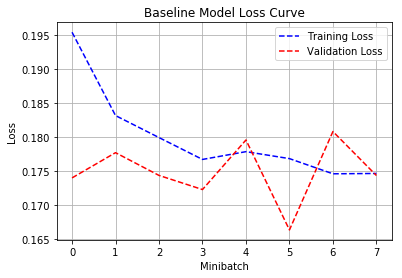

In [17]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("Baseline Model Loss Curve")
plt.legend(loc="upper right")

plt.savefig("images/m0_loss.png")

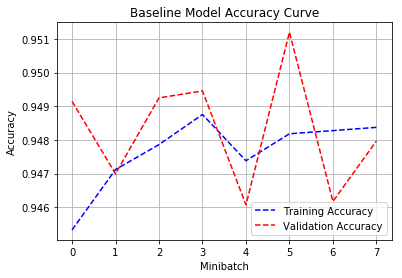

In [18]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m0_acc.png")

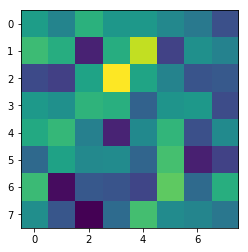

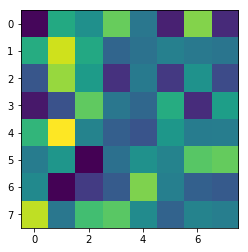

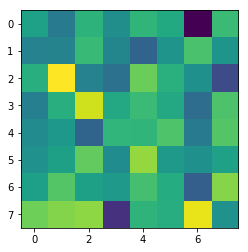

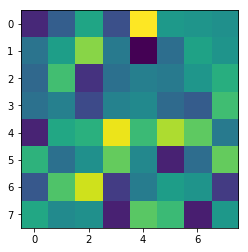

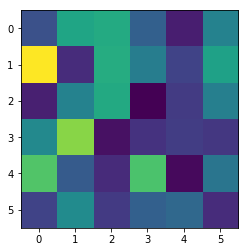

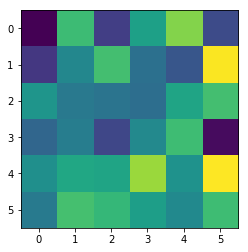

In [19]:
weights = model.conv1.weight.data.cpu().numpy()
plt.imsave('images/m0_early1.png', weights[0, 0])
plt.imsave('images/m0_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv2.weight.data.cpu().numpy()
plt.imsave('images/m0_mid1.png', weights[0, 0])
plt.imsave('images/m0_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv3.weight.data.cpu().numpy()
plt.imsave('images/m0_last1.png', weights[0, 0])
plt.imsave('images/m0_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [21]:
# CUSTOM MODEL 1

# Define the model architecture and parameters
channel = [1, 8, 8, 8, 16, 16, 16, 32, 32, 32]
block_size = 3
kernel = [5]*9
pool_kernel = 2
pool_stride = 2
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# Instantiate a BasicCNN to run on the GPU or CPU based on CUDA support
model = Model1CNN(256, channel, kernel, block_size, pool_kernel, pool_stride)
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Custom1', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)

# Normalize the confusion matrix
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j])
        

print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")
print(conf_mtx)

CUDA is supported
Model on CUDA? True
Epoch 1, average minibatch 49 loss: 0.277
0.9200150206533985 % done,  57.30289816856384  Seconds elapsed
Epoch 1, average minibatch 99 loss: 0.205
1.8588058580548255 % done,  111.4372775554657  Seconds elapsed
Epoch 1, average minibatch 149 loss: 0.202
2.7975966954562526 % done,  165.2307517528534  Seconds elapsed
Epoch 1, average minibatch 199 loss: 0.191
3.7363875328576794 % done,  218.78625869750977  Seconds elapsed
Epoch 1, average minibatch 249 loss: 0.190
4.675178370259106 % done,  272.3890435695648  Seconds elapsed
Epoch 1, average minibatch 299 loss: 0.181
5.613969207660533 % done,  324.5456335544586  Seconds elapsed
Epoch 1, average minibatch 349 loss: 0.185
6.5527600450619605 % done,  377.3447413444519  Seconds elapsed
Epoch 1, average minibatch 399 loss: 0.188
7.491550882463387 % done,  430.45945382118225  Seconds elapsed
Epoch 1, average minibatch 449 loss: 0.175
8.430341719864813 % done,  483.1413793563843  Seconds elapsed
Epoch 1, ave

Epoch 1, average minibatch 3899 loss: 0.168
73.20690950056327 % done,  4114.632451057434  Seconds elapsed
Epoch 1, average minibatch 3949 loss: 0.175
74.1457003379647 % done,  4167.716033935547  Seconds elapsed
Epoch 1, average minibatch 3999 loss: 0.169
75.08449117536613 % done,  4220.977267026901  Seconds elapsed
Epoch 1, average minibatch 4049 loss: 0.175
76.02328201276755 % done,  4274.292125463486  Seconds elapsed
Epoch 1, average minibatch 4099 loss: 0.173
76.96207285016898 % done,  4327.262346744537  Seconds elapsed
Epoch 1, average minibatch 4149 loss: 0.173
77.9008636875704 % done,  4380.027923345566  Seconds elapsed
Epoch 1, average minibatch 4199 loss: 0.178
78.83965452497183 % done,  4433.0753698349  Seconds elapsed
Epoch 1, average minibatch 4249 loss: 0.169
79.77844536237326 % done,  4485.905994653702  Seconds elapsed
Epoch 1, average minibatch 4299 loss: 0.176
80.71723619977469 % done,  4538.725967645645  Seconds elapsed
Epoch 1, average minibatch 4349 loss: 0.174
81.656

Epoch 2, average minibatch 2449 loss: 0.159
45.98197521592189 % done,  8586.936305999756  Seconds elapsed
Epoch 2, average minibatch 2499 loss: 0.165
46.92076605332332 % done,  8640.144711971283  Seconds elapsed
Epoch 2, average minibatch 2549 loss: 0.163
47.85955689072475 % done,  8693.673327445984  Seconds elapsed
Epoch 2, average minibatch 2599 loss: 0.166
48.798347728126174 % done,  8747.579967021942  Seconds elapsed
Epoch 2, average minibatch 2649 loss: 0.165
49.7371385655276 % done,  8800.715362071991  Seconds elapsed
Epoch 2, average minibatch 2699 loss: 0.166
50.67592940292903 % done,  8853.900087356567  Seconds elapsed
Epoch 2, average minibatch 2749 loss: 0.166
51.614720240330456 % done,  8907.129366397858  Seconds elapsed
Epoch 2, average minibatch 2799 loss: 0.180
52.55351107773188 % done,  8960.34737610817  Seconds elapsed
Epoch 2, average minibatch 2849 loss: 0.173
53.49230191513331 % done,  9014.027261734009  Seconds elapsed
Epoch 2, average minibatch 2899 loss: 0.168
54

----- Aggregated Scores -----
Minibatch 599 accuracy: 0.9475
Minibatch 599 precision: 0.10333333333333332
Minibatch 599 recall: 0.02413696448479057
Minibatch 599 bcr: 0.06373514890906196
----- Aggregated Scores -----
Minibatch 649 accuracy: 0.9493749999999999
Minibatch 649 precision: 0.13333333333333333
Minibatch 649 recall: 0.02747473604826546
Minibatch 649 bcr: 0.08040403469079939
----- Aggregated Scores -----
Minibatch 699 accuracy: 0.9526785714285714
Minibatch 699 precision: 0.11
Minibatch 699 recall: 0.020007437007437002
Minibatch 699 bcr: 0.0650037185037185
----- Aggregated Scores -----
Minibatch 749 accuracy: 0.9484821428571428
Minibatch 749 precision: 0.04333333333333333
Minibatch 749 recall: 0.008356643356643356
Minibatch 749 bcr: 0.025844988344988343
----- Aggregated Scores -----
Minibatch 799 accuracy: 0.9469642857142857
Minibatch 799 precision: 0.12
Minibatch 799 recall: 0.0226156787230956
Minibatch 799 bcr: 0.0713078393615478
----- Aggregated Scores -----
Minibatch 849 acc

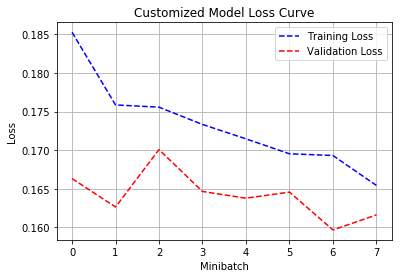

In [22]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("Customized Model Loss Curve")
plt.legend(loc="upper right")

plt.savefig("images/m1_loss.png")

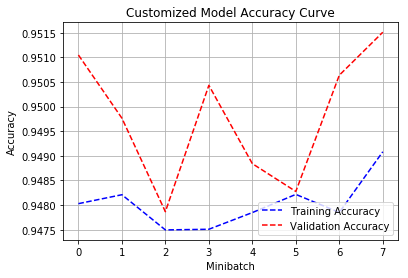

In [23]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("Customized Model Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m1_acc.png")

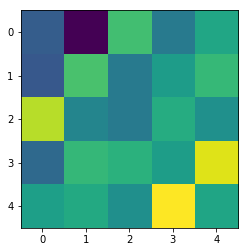

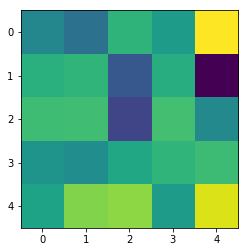

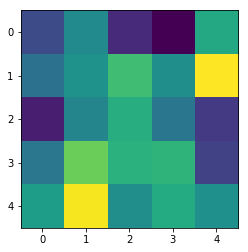

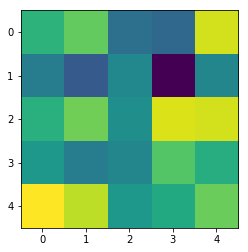

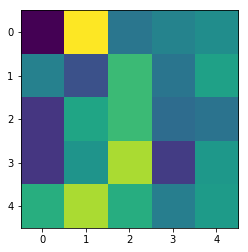

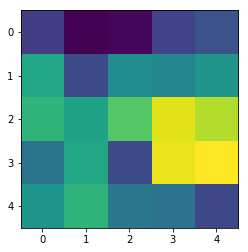

In [25]:
weights = model.conv[2].weight.data.cpu().numpy()
plt.imsave('images/m1_early1.png', weights[0, 0])
plt.imsave('images/m1_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv[5].weight.data.cpu().numpy()
plt.imsave('images/m1_mid1.png', weights[0, 0])
plt.imsave('images/m1_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv[8].weight.data.cpu().numpy()
plt.imsave('images/m1_last1.png', weights[0, 0])
plt.imsave('images/m1_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [ ]:
# CUSTOM MODEL 2

# Define the model parameters
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# trains the model
model = Model2CNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Custom2', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)

# Normalize the confusion matrix
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j])


print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")
print(conf_mtx)

In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("ResNet12 Loss Curve")
plt.legend(loc='upper right')

plt.savefig("images/m2_loss.png")

In [ ]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("ResNet12 Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m2_acc.png")

In [ ]:
weights = model.conv3.weight.data.cpu().numpy()
plt.imsave('images/m2_early1.png', weights[0, 0])
plt.imsave('images/m2_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv6.weight.data.cpu().numpy()
plt.imsave('images/m2_mid1.png', weights[0, 0])
plt.imsave('images/m2_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv12.weight.data.cpu().numpy()
plt.imsave('images/m2_last1.png', weights[0, 0])
plt.imsave('images/m2_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [ ]:
# RERUN CUSTOM MODEL 2 WITH CLASS BALANCING

# Define the model parameters
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# Creates the weights to address the class imbalance
total_data_points = 0
if use_cuda:
    total_class_counts = torch.cuda.FloatTensor(14).fill_(0)
else:
    total_class_counts = torch.FloatTensor(14).fill_(0)
    
N = 50
NN = 100
for minibatch_count, (images, labels) in enumerate(train_loader, 0):
    total_data_points += labels.shape[0]
    total_class_counts += torch.sum(labels, dim = 0).cuda()
    if (minibatch_count + 1) % N == 0:
        print("Finished counting minibatch " + str(minibatch_count + 1))
        print("Total data points = " + str(total_data_points))
        print("Total class counts = " + str(total_class_counts))
    if (minibatch_count + 1) % NN == 0:
        break
    
inverse_class_frequency = (total_data_points - total_class_counts) / (total_class_counts + 1)
    
print('--------------------------------------------------------------------------')
print("Inverse Class Frequency")
print(inverse_class_frequency)


# Train the model
model = Model2CNN(skip_sigmoid=True)
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=inverse_class_frequency)

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Custom2ClassBalance', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)

# Normalize the confusion matrix
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j])
        

print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")      
print(conf_mtx)

CUDA is supported
Finished counting minibatch 50
Total data points = 800
Total class counts = tensor([ 93.,  20.,  98., 151.,  34.,  40.,  13.,  33.,  32.,  15.,  20.,  20.,
         21.,   1.], device='cuda:0')
Finished counting minibatch 100
Total data points = 1600
Total class counts = tensor([185.,  37., 195., 304.,  81.,  80.,  31.,  69.,  67.,  26.,  37.,  28.,
         42.,   3.], device='cuda:0')
--------------------------------------------------------------------------
Inverse Class Frequency
tensor([  7.6075,  41.1316,   7.1684,   4.2492,  18.5244,  18.7654,  49.0312,
         21.8714,  22.5441,  58.2963,  41.1316,  54.2069,  36.2326, 399.2500],
       device='cuda:0')
Model on CUDA? True
Epoch 1, average minibatch 50 loss: 1.280
0.9200150206533985 % done,  54.89784240722656  Seconds elapsed
Epoch 1, average minibatch 100 loss: 1.325
1.8588058580548255 % done,  107.62205696105957  Seconds elapsed
Epoch 1, average minibatch 150 loss: 1.287
2.7975966954562526 % done,  160.51974

Epoch 1, average minibatch 3600 loss: 1.188
67.5741644761547 % done,  3757.50367808342  Seconds elapsed
Epoch 1, average minibatch 3650 loss: 1.124
68.51295531355613 % done,  3810.3477885723114  Seconds elapsed
Epoch 1, average minibatch 3700 loss: 1.152
69.45174615095756 % done,  3862.5054631233215  Seconds elapsed
Epoch 1, average minibatch 3750 loss: 1.206
70.39053698835899 % done,  3914.4202449321747  Seconds elapsed
Epoch 1, average minibatch 3800 loss: 1.145
71.32932782576042 % done,  3966.4851047992706  Seconds elapsed
Epoch 1, average minibatch 3850 loss: 1.212
72.26811866316184 % done,  4018.5916340351105  Seconds elapsed
Epoch 1, average minibatch 3900 loss: 1.128
73.20690950056327 % done,  4070.7271716594696  Seconds elapsed
Epoch 1, average minibatch 3950 loss: 1.129
74.1457003379647 % done,  4123.252202272415  Seconds elapsed
Epoch 1, average minibatch 4000 loss: 1.198
75.08449117536613 % done,  4175.6493282318115  Seconds elapsed
Epoch 1, average minibatch 4050 loss: 1.17

Epoch 2, average minibatch 2150 loss: 1.080
40.34923019151333 % done,  8202.689934968948  Seconds elapsed
Epoch 2, average minibatch 2200 loss: 1.066
41.288021028914756 % done,  8255.464331626892  Seconds elapsed
Epoch 2, average minibatch 2250 loss: 1.265
42.22681186631618 % done,  8307.266723394394  Seconds elapsed
Epoch 2, average minibatch 2300 loss: 1.160
43.16560270371761 % done,  8360.23028087616  Seconds elapsed
Epoch 2, average minibatch 2350 loss: 1.085
44.10439354111904 % done,  8413.650641918182  Seconds elapsed
Epoch 2, average minibatch 2400 loss: 1.072
45.043184378520465 % done,  8467.175060272217  Seconds elapsed
Epoch 2, average minibatch 2450 loss: 1.171
45.98197521592189 % done,  8519.421939849854  Seconds elapsed
Epoch 2, average minibatch 2500 loss: 1.161
46.92076605332332 % done,  8572.218732357025  Seconds elapsed
Epoch 2, average minibatch 2550 loss: 1.109
47.85955689072475 % done,  8625.1656396389  Seconds elapsed
Epoch 2, average minibatch 2600 loss: 1.162
48.

----- Aggregated Scores -----
Minibatch 399 accuracy: 0.6710714285714284
Minibatch 399 precision: 0.09262011365611908
Minibatch 399 recall: 0.5389801222169643
Minibatch 399 bcr: 0.31580011793654167
----- Aggregated Scores -----
Minibatch 449 accuracy: 0.6884821428571428
Minibatch 449 precision: 0.09077609719008488
Minibatch 449 recall: 0.5641196303696303
Minibatch 449 bcr: 0.32744786377985763
----- Aggregated Scores -----
Minibatch 499 accuracy: 0.660982142857143
Minibatch 499 precision: 0.09608821041501572
Minibatch 499 recall: 0.5838238823552123
Minibatch 499 bcr: 0.339956046385114
----- Aggregated Scores -----
Minibatch 549 accuracy: 0.6760714285714287
Minibatch 549 precision: 0.08860854524694012
Minibatch 549 recall: 0.5568641521876817
Minibatch 549 bcr: 0.32273634871731083
----- Aggregated Scores -----
Minibatch 599 accuracy: 0.6774107142857143
Minibatch 599 precision: 0.09719542361110724
Minibatch 599 recall: 0.5595999224087459
Minibatch 599 bcr: 0.32839767300992656
----- Aggrega

In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("ResNet12 With Class Balancing Loss Curve")
plt.legend(loc='upper right')

plt.savefig("images/m3_loss.png")

In [ ]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("ResNet12 With Class Balancing Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m3_acc.png")

In [ ]:
weights = model.conv3.weight.data.cpu().numpy()
plt.imsave('images/m3_early1.png', weights[0, 0])
plt.imsave('images/m3_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv6.weight.data.cpu().numpy()
plt.imsave('images/m3_mid1.png', weights[0, 0])
plt.imsave('images/m3_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv12.weight.data.cpu().numpy()
plt.imsave('images/m3_last1.png', weights[0, 0])
plt.imsave('images/m3_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [ ]:
# Loads the model
model2 = torch.load('file_name')